# Introduction

We need to set up the data loading function, which will involve many moving parts. I have generated networkx objects that can be read in but the code base for [U2GNN](https://github.com/daiquocnguyen/Graph-Transformer) does not take those, and instead takes in S2Vgraph objects 

## Installing Packages

Installing the relevant packages to the VM. From the repo, seems like we will need
* Python 3.x
* Tensorflow 1.14 & Tensor2tensor 1.13
* Pytorch >= 1.5.0
* Networkx 2.3
* Scikit-learn 0.21.2

In [1]:
!pip install -q --upgrade pip
!pip install -q torch==2.0.1
!pip install -q 'matplotlib<3.7'
!pip install -q scikit-spatial
!pip install -q networkx
!pip install -q scikit-learn
!pip install -q umap-learn

In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

print(torch.cuda.is_available())
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())

2.0.1+cu117
True
2.0.1+cu117
11.7
0
Tesla T4


## Importing Packages

In [3]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch_geometric
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing
import pickle
import re
import scipy.sparse as sp
from sklearn.model_selection import StratifiedKFold

## Cloning github repo

In [4]:
home_dir = os.getcwd()

In [5]:
git_repo_dir = home_dir + '/u2gnn'
!rm -rf $git_repo_dir
!mkdir $git_repo_dir
!cd $git_repo_dir
!git clone https://github.com/daiquocnguyen/Graph-Transformer.git $git_repo_dir

Cloning into '/home/jupyter/complex_SVs/edit/u2gnn'...
remote: Enumerating objects: 700, done.
remote: Counting objects: 100% (485/485), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 700 (delta 273), reused 436 (delta 237), pack-reused 215
Receiving objects: 100% (700/700), 112.09 MiB | 35.88 MiB/s, done.
Resolving deltas: 100% (398/398), done.


[This issue](https://github.com/daiquocnguyen/Graph-Transformer/issues/8) says we have to make `LogUniformSampler` 

In [6]:
%%capture
os.chdir(home_dir)
# Compile the log uniform sampler
log_unif_dir = git_repo_dir + '/UGformerV1_PyTorch/log_uniform/'
os.chdir(log_unif_dir)
!make
os.chdir(home_dir)
# Set it in pythonpath
os.environ["PYTHONPATH"] = os.path.abspath(log_unif_dir) + ':' + \
    os.path.abspath(git_repo_dir + '/UGformerV1_PyTorch/') + ':' + \
    os.environ["PYTHONPATH"] 
os.environ["PYTHONPATH"] = re.sub(
    '/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch/log_uniform:/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch/log_uniform',
    '/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch/log_uniform',
    os.environ["PYTHONPATH"]
)
os.environ["PATH"] = os.path.abspath(log_unif_dir) + ':' + \
    os.path.abspath(git_repo_dir + '/UGformerV1_PyTorch/') + ':' + \
    os.environ["PATH"]
os.environ["PATH"] = re.sub(
    '/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch/log_uniform:/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch/log_uniform',
    '/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch/log_uniform',
    os.environ["PATH"]
)

In [7]:
print(os.environ["PYTHONPATH"])
print(os.environ["PATH"])

/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch/log_uniform:/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch:/etc/jupyter/custom:/usr/lib/spark/python:/home/jupyter/packages
/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch/log_uniform:/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch:/opt/conda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/jupyter/.local/bin:/home/jupyter/packages/bin


## Localizing data from the bucket

In [8]:
BILLING_PROJECT_ID = os.environ['WORKSPACE_NAMESPACE']
WORKSPACE = os.environ['WORKSPACE_NAME']
bucket = os.environ['WORKSPACE_BUCKET']

In [9]:
# Copy all files from the workspace bucket to the notebook disk
!gsutil -q cp -n $bucket/test_graphs/test.txt $home_dir

# Run list command to see if file is in the notebook disk
!readlink -m ./test.txt

/home/jupyter/complex_SVs/edit/test.txt


## Reading in graphs

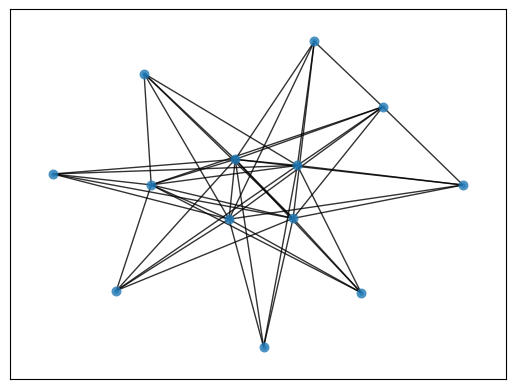

In [10]:
G = pickle.load(open("./test.txt", 'rb'))
nx.draw_networkx(
    G.subgraph([n for n in G.nodes if 'efe4d5dd-fffb-41df-ab86-be06cc16646f_19_' in n]), 
    node_size = 10, with_labels = False, alpha = 0.8, linewidths = 4
)

# Convert Nx graph to S2VGraph

## S2VGraph Definition

In [11]:
"""Adapted from https://github.com/weihua916/powerful-gnns/blob/master/util.py"""

class S2VGraph(object):
    def __init__(self, g, label, node_tags=None, node_features=None):
        '''
            g: a networkx graph
            label: an integer graph label
            node_tags: a list of integer node tags
            node_features: a torch float tensor, one-hot representation of the tag that is used as input to neural nets
            edge_mat: a torch long tensor, contain edge list, will be used to create torch sparse tensor
            neighbors: list of neighbors (without self-loop)
        '''
        self.label = label
        self.g = g
        self.node_tags = node_tags
        self.neighbors = []
        self.node_features = 0
        self.edge_mat = 0
        self.max_neighbor = 0

## Loading Data Function

**Input for the load data function will be a list of strings indicating where the graphs are located on disk**

In [12]:
def create_s2v(graph_file):
    G = pickle.load(open(graph_file, 'rb'))
    # relabel nodes to integer
    G = nx.relabel_nodes(G, {n: int(re.sub('.*_', '',n)) for n in G.nodes})
    # use fake label of 0 for everything
    return S2VGraph(G, label = 0)

def load_data_from_nx(graph_files):
    num_cores = multiprocessing.cpu_count()
    g_list = Parallel(n_jobs = num_cores)(
        delayed(create_s2v)(graph_file) for graph_file in graph_files if len(pickle.load(open(graph_file, 'rb')).edges()) > 0
    )

    #add edge_mat and node_features     
    for g in g_list:
        # adding .neighbors
        g.neighbors = [[] for i in range(len(g.g))]
        for i, j in g.g.edges():
            g.neighbors[i].append(j)
            g.neighbors[j].append(i)
        degree_list = []
        for i in range(len(g.g)):
            g.neighbors[i] = g.neighbors[i]
            degree_list.append(len(g.neighbors[i]))
        # adding .max_neighbor
        g.max_neighbor = max(degree_list)

        #g.label = label_dict[g.label]

        # adding edge_mat
        edges = [list(pair) for pair in g.g.edges()]
        edges.extend([[i, j] for j, i in edges])
        g.edge_mat = np.transpose(np.array(edges, dtype=np.int32), (1,0))
        # deg_list = list(dict(g.g.degree(range(len(g.g)))).values())

        # node features
        g.node_features = np.array([
            np.array(list(g.g.nodes()[i].values()), dtype=np.float32) 
            for i in g.g.nodes()
        ])
        
    return g_list

## Load S2VGraphs From the Bucket

In [13]:
# Copy all files from the workspace bucket to the notebook disk
graph_dir = home_dir + '/graphs'
!mkdir -p $graph_dir
!gsutil -q cp -n $bucket/nx_graphs/nx/* $graph_dir
!ls -l $graph_dir | wc -l
# input list of graph text files
nx_files = [
    graph_dir + '/' + f for f in os.listdir(graph_dir) if f.endswith('_nx_graph.txt')
]

14629


# Other Util Methods

In [14]:
"""Get indexes of train and test sets"""
def separate_data_idx(graph_list, fold_idx, seed=0):
    assert 0 <= fold_idx and fold_idx < 10, "fold_idx must be from 0 to 9."
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

    labels = [graph.label for graph in graph_list]
    idx_list = []
    for idx in skf.split(np.zeros(len(labels)), labels):
        idx_list.append(idx)
    train_idx, test_idx = idx_list[fold_idx]

    return train_idx, test_idx

In [15]:
"""Convert sparse matrix to tuple representation."""
def sparse_to_tuple(sparse_mx):
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx

# Train Unsupervised Model

## Importing the necessary functions in the repo

In [16]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(123)

import numpy as np
np.random.seed(123)
import time

# ==================== ADDITIONAL CODE TO MAKE IMPORT WORK ====================
import sys 
import pyximport
sys.path.append(os.path.abspath(git_repo_dir+'/UGformerV1_PyTorch'))
sys.path.append(os.path.abspath(git_repo_dir+'/UGformerV1_PyTorch/log_uniform'))
# install from the log_uniform.pyx file. If not, the `import log_uniform` default to `log_uniform.*.so`
pyximport.install()
os.chdir('/home/jupyter/complex_SVs/edit')
os.chdir(git_repo_dir+'/UGformerV1_PyTorch')
# =============================================================================

from UGformerV1_UnSup import *
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
from scipy.sparse import coo_matrix
from util import *
from sklearn.linear_model import LogisticRegression
import statistics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(123)

## Prep Args

In [17]:
os.chdir(git_repo_dir+'/UGformerV1_PyTorch')

import argparse
args = argparse.Namespace()
args.run_folder = '../'
args.dataset = 'custom'
args.learning_rate = 0.001
args.batch_size = 8
args.num_epochs = 50
args.model_name = 'complexSV'
args.sampled_num = 512
args.dropout = 0.5
args.num_hidden_layers = 1
args.num_timesteps = 2
args.ff_hidden_size = 1024
args.num_neighbors = 10
args.fold_idx = 1

## Load data

In [18]:
# Load data
print("Loading data...")

use_degree_as_tag = False
    
graphs = load_data_from_nx(nx_files)
num_classes = 1
graph_labels = np.array([graph.label for graph in graphs])
feature_dim_size = graphs[0].node_features.shape[1]
print(feature_dim_size)

Loading data...
90


Everything is now adapted from [code here](https://github.com/daiquocnguyen/Graph-Transformer/blob/master/UGformerV1_PyTorch/train_UGformerV1_UnSup.py#L148)

In [19]:
def get_Adj_matrix(batch_graph):
    edge_mat_list = []
    start_idx = [0]
    for i, graph in enumerate(batch_graph):
        start_idx.append(start_idx[i] + len(graph.g))
        edge_mat_list.append(graph.edge_mat + start_idx[i])

    Adj_block_idx = np.concatenate(edge_mat_list, 1)
    # Adj_block_elem = np.ones(Adj_block_idx.shape[1])

    Adj_block_idx_row = Adj_block_idx[0,:]
    Adj_block_idx_cl = Adj_block_idx[1,:]

    return Adj_block_idx_row, Adj_block_idx_cl

def get_graphpool(batch_graph):
    start_idx = [0]
    # compute the padded neighbor list
    for i, graph in enumerate(batch_graph):
        start_idx.append(start_idx[i] + len(graph.g))

    idx = []
    elem = []
    for i, graph in enumerate(batch_graph):
        elem.extend([1] * len(graph.g))
        idx.extend([[i, j] for j in range(start_idx[i], start_idx[i + 1], 1)])

    elem = torch.FloatTensor(elem)
    idx = torch.LongTensor(idx).transpose(0, 1)
    graph_pool = torch.sparse.FloatTensor(idx, elem, torch.Size([len(batch_graph), start_idx[-1]]))

    return graph_pool.to(device)

print('Beginning graph pool')
graph_pool = get_graphpool(graphs)
graph_indices = graph_pool._indices()[0]
vocab_size=graph_pool.size()[1]

def get_idx_nodes(selected_graph_idx):
    idx_nodes = [torch.where(graph_indices==i)[0] for i in selected_graph_idx]
    idx_nodes = torch.cat(idx_nodes)
    return idx_nodes.to(device)

def get_batch_data(selected_idx):
    batch_graph = [graphs[idx] for idx in selected_idx]

    X_concat = np.concatenate([graph.node_features for graph in batch_graph], 0)
    if "REDDIT" in args.dataset:
        X_concat = np.tile(X_concat, feature_dim_size) #[1,1,1,1]
        X_concat = X_concat * 0.01
    X_concat = torch.from_numpy(X_concat).to(device)

    Adj_block_idx_row, Adj_block_idx_cl = get_Adj_matrix(batch_graph)
    dict_Adj_block = {}
    for i in range(len(Adj_block_idx_row)):
        if Adj_block_idx_row[i] not in dict_Adj_block:
            dict_Adj_block[Adj_block_idx_row[i]] = []
        dict_Adj_block[Adj_block_idx_row[i]].append(Adj_block_idx_cl[i])

    input_neighbors = []
    for input_node in range(X_concat.shape[0]):
        if input_node in dict_Adj_block:
            input_neighbors.append([input_node] + list(np.random.choice(dict_Adj_block[input_node], args.num_neighbors, replace=True)))
        else:
            input_neighbors.append([input_node for _ in range(args.num_neighbors + 1)])
    input_x = np.array(input_neighbors)
    input_x = torch.transpose(torch.from_numpy(input_x), 0, 1).to(device)  # [seq_length, batch_size] for pytorch transformer, not [batch_size, seq_length]

    input_y = get_idx_nodes(selected_idx)

    return X_concat, input_x, input_y

print("Loading data... finished!")

Beginning graph pool
Loading data... finished!


## Model Setup

In [20]:
model = UGformerV1(feature_dim_size=feature_dim_size, ff_hidden_size=args.ff_hidden_size,
                        dropout=args.dropout, num_self_att_layers=args.num_timesteps,
                        vocab_size=vocab_size, sampled_num=args.sampled_num,
                        num_GNN_layers=args.num_hidden_layers, device=device).to(device) #Each UGformer layer consists of a number of self-attention layers

optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
num_batches_per_epoch = int((len(graphs) - 1) / args.batch_size) + 1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_batches_per_epoch, gamma=0.1)

def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    indices = np.arange(0, len(graphs))
    np.random.shuffle(indices)
    for start in range(0, len(graphs), args.batch_size):
        end = start + args.batch_size
        selected_idx = indices[start:end]
        X_concat, input_x, input_y = get_batch_data(selected_idx)
        optimizer.zero_grad()
        logits = model(X_concat, input_x, input_y)
        loss = torch.sum(logits)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        total_loss += loss.item()

    return total_loss

## Debug training

In [21]:
indices = np.arange(0, len(graphs))
np.random.shuffle(indices)
start = 0
end = start + args.batch_size
selected_idx = indices[start:end]
X_concat, input_x, input_y = get_batch_data(selected_idx)
print(X_concat)
print(input_x)
print(input_y)
print(model.ugformer_layers[0](F.embedding(input_x, X_concat))[0])

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.3013, 0.2776, 0.1267],
        [0.0000, 0.0000, 0.0000,  ..., 0.3013, 0.2776, 0.1267],
        [0.0000, 0.0000, 0.0000,  ..., 0.3013, 0.2776, 0.1267],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.3013, 0.2494, 0.2008],
        [0.0000, 0.0000, 0.0000,  ..., 0.3013, 0.2494, 0.2008],
        [0.0000, 0.0000, 0.0000,  ..., 0.3013, 0.2494, 0.2008]],
       device='cuda:0')
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18],
        [ 2,  2,  1,  3,  5,  4,  8,  6, 12,  6,  9,  7,  9, 12, 16, 14, 14, 18,
         14],
        [ 2,  2,  0,  3,  5,  4,  7, 10,  6,  8,  9,  9,  9, 10, 15, 14, 18, 18,
         16],
        [ 2,  2,  1,  3,  5,  4,  8,  9,  9,  6,  8,  7,  8,  9, 16, 14, 15, 18,
         14],
        [ 2,  2,  0,  3,  5,  4,  8, 11,  9, 10,  6,  7,  7, 10, 15, 14, 14, 18,
         17]], device='cuda:0')
tensor([17169, 17170, 17171, 10731, 10732, 10733, 25852, 25853, 25854, 25855,
       

## Training the model

In [22]:
"""main process"""
import os
out_dir = os.path.abspath(os.path.join(args.run_folder, "../runs_UGformerV2_UnSup", args.model_name))
print("Writing to {}\n".format(out_dir))
# Checkpoint directory
checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
checkpoint_prefix = os.path.join(checkpoint_dir, "model")
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
write_acc = open(checkpoint_prefix + '_acc.txt', 'w')

cost_loss = []

for epoch in range(1, args.num_epochs + 1):
    epoch_start_time = time.time()
    train_loss = train()
    cost_loss.append(train_loss)
    # We don't have true labels, so we cannot run the evaluate function
    # mean_10folds, std_10folds = evaluate()
    # print('| epoch {:3d} | time: {:5.2f}s | loss {:5.2f} | mean {:5.2f} | std {:5.2f} | '.format(
                # epoch, (time.time() - epoch_start_time), train_loss, mean_10folds*100, std_10folds*100))

    print('| epoch {:3d} | time: {:5.2f}s | loss {:5.2f} | '.format(
            epoch, (time.time() - epoch_start_time), train_loss))

    if epoch > 5 and cost_loss[-1] > np.mean(cost_loss[-6:-1]):
        scheduler.step()

    write_acc.write('epoch ' + str(epoch) + '\n')

write_acc.close()

Writing to /home/jupyter/complex_SVs/edit/runs_UGformerV2_UnSup/complexSV

| epoch   1 | time: 45.59s | loss 487578.47 | 
| epoch   2 | time: 45.77s | loss 474592.76 | 
| epoch   3 | time: 45.98s | loss 475072.12 | 
| epoch   4 | time: 45.87s | loss 477384.35 | 
| epoch   5 | time: 45.88s | loss 482262.80 | 
| epoch   6 | time: 46.03s | loss 485427.78 | 
| epoch   7 | time: 45.72s | loss 489189.79 | 
| epoch   8 | time: 46.03s | loss 494058.37 | 
| epoch   9 | time: 45.81s | loss 495690.61 | 
| epoch  10 | time: 45.59s | loss 498286.32 | 
| epoch  11 | time: 45.94s | loss 497741.24 | 
| epoch  12 | time: 45.85s | loss 500519.18 | 
| epoch  13 | time: 45.75s | loss 502205.80 | 
| epoch  14 | time: 45.88s | loss 502948.69 | 
| epoch  15 | time: 45.65s | loss 505026.35 | 
| epoch  16 | time: 45.82s | loss 503671.05 | 
| epoch  17 | time: 47.21s | loss 504967.95 | 
| epoch  18 | time: 46.03s | loss 505551.93 | 
| epoch  19 | time: 45.86s | loss 505833.28 | 
| epoch  20 | time: 45.99s | los

In [23]:
torch.save(model.state_dict(), home_dir+'/model.pt')

## Visualization

In [24]:
model = UGformerV1(feature_dim_size=feature_dim_size, ff_hidden_size=args.ff_hidden_size,
                        dropout=args.dropout, num_self_att_layers=args.num_timesteps,
                        vocab_size=vocab_size, sampled_num=args.sampled_num,
                        num_GNN_layers=args.num_hidden_layers, device=device).to(device) #Each UGformer layer consists of a number of self-attention layers
model.load_state_dict(torch.load(home_dir+'/model.pt'))

model.eval() # Turn on the evaluation mode
with torch.no_grad():
    # evaluating
    node_embeddings = model.ss.weight
    graph_embeddings = torch.spmm(graph_pool, node_embeddings).data.cpu().numpy()

/tmp/ipykernel_867/3417790278.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], s=2, cmap='Spectral')


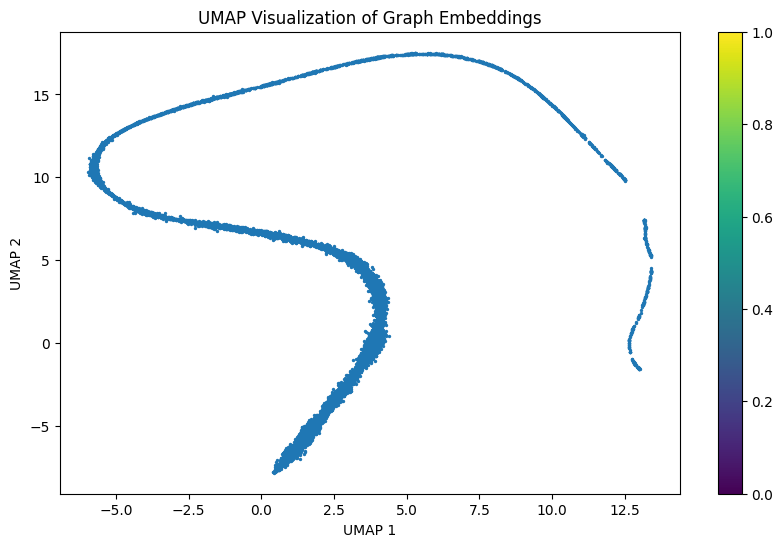

In [25]:
import umap.umap_ as umap

# UMAP dimensionality reduction
reducer = umap.UMAP()
embedding = reducer.fit_transform(graph_embeddings)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], s=2, cmap='Spectral')
plt.title('UMAP Visualization of Graph Embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar()
plt.show()

In [28]:
graph_embeddings.shape

(10579, 90)